In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
import scipy.special as special
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as npr
%matplotlib inline

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

[[1000.  997.  992. ...    9.    9.    9.]
 [   0.    3.    8. ...  991.  991.  991.]]


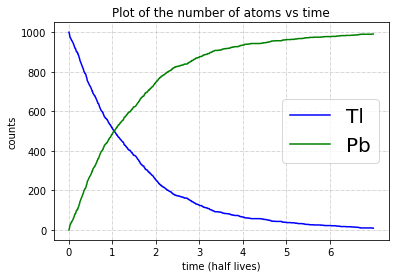

In [2]:
Tl=1000
Pb=0
tau=3.052*60
N=round(7*tau)
def p(t):
    p=1-2**(-t/tau)
    return p
TlPb_t=np.empty((2,N))
time=np.arange(0,N)


for i in range (0,N):
    TlPb_t[0,i]=Tl
    TlPb_t[1,i]=Pb
    dist=npr.rand(Tl)
    val=p(1)
    decaded=(dist<val)
    Tl=Tl-dist[decaded].size
    Pb=Pb+dist[decaded].size
print(TlPb_t)

plt.plot(time/tau, TlPb_t[0,:], color = 'blue',label = 'Tl')
plt.plot(time/tau, TlPb_t[1,:], color = 'green', label = 'Pb')
plt.grid(linestyle="dashdot", linewidth=0.5)
plt.legend(prop={'size': 20})
plt.xlabel('time (half lives)')
plt.ylabel('counts')
plt.title('Plot of the number of atoms vs time')
plt.xticks(ticks=np.arange(0,7,1))
plt.show()

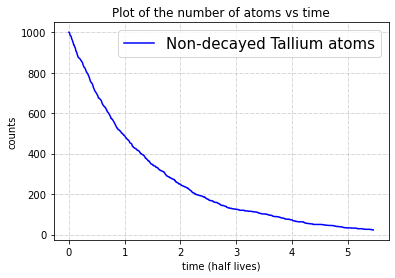

In [3]:
def f(z):
    t = -tau*np.log2(1-z)
    return t


N = 1000
Z = npr.random(1000)
T = f(Z)
time = np.arange(0,N,1)
surv = np.empty(N)
for t in time:
    y = (T > t)
    surv[t] = len(T[y])

plt.plot(time/tau, surv, color = 'blue',label = 'Non-decayed Tallium atoms')
plt.title('Plot of the number of Tallium atoms vs time')
plt.grid(linestyle="dashdot", linewidth=0.5)
plt.legend(prop={'size': 15})
plt.xlabel('time (half lives)')
plt.ylabel('counts')
plt.title('Plot of the number of atoms vs time')
plt.xticks(ticks=np.arange(0,6,1))
plt.show()


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [39]:
Z=79
e=1.602e-19
E=7.7e6*e
epsilon0 = 8.854e-12
a0 = 5.292e-11
sigma = a0/100
N = 10**6

def tant2 (b):
    par=Z*e*e/(2*np.pi*epsilon0*E*b)
    return par

def f(p):
    r = np.sqrt(-2*sigma*sigma*np.log(1-p))
    return r

P=npr.random(10**6)
    
B=f(P)

#plt.hist(B,bins="auto")

res=tant2(B)
    
deflected = (res > 1)

num_deflected=res[deflected].size
    
print("Out of the 10^6 particles, only ",num_deflected," are deflected.\n")

Out of the 10^6 particles, only  1548  are deflected.



3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

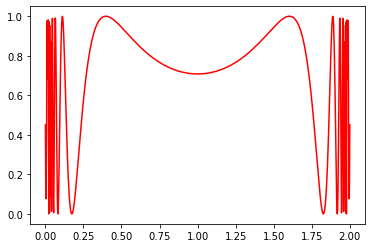

In [35]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'r-')

In [36]:
#Hit or miss integration
N=10**6
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I_hm=2*count/N

p = count/N                          
sigma_hm = 2*np.sqrt(N*p*(1-p))/N   #(binomial)
print('Integral hit miss method:\t %.4f +/- %.4f.' % (I_hm,sigma_hm))


Integral hit miss method:	 1.4516 +/- 0.0009.


In [37]:
#Mean value method
I_mv_sum = 0
squares_sum = 0
for i in range(N):
    x=2*npr.random()
    I_mv_sum += f(x)
    squares_sum += f(x)**2
I_mv=(2/N)*I_mv_sum
Square = ((1/N)*(I_mv_sum))**2
sigf = np.sqrt((squares_sum/N)-Square)
sigma_mv = 2*sigf*np.sqrt(1/N)

print('Integral mean value method:\t %.4f +/- %.4f.\nThis one has a lower error.' % (I_mv,sigma_mv))


Integral mean value method:	 1.4513 +/- 0.0005.
This one has a lower error.


In [38]:
#integral done by mathematica
I_mat=1.451401485391766
print("Result given by Mathematica:\t %.4f"%I_mat)

Result given by Mathematica:	 1.4514


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [29]:
#2D sphere
def radius_sq(coords):
    radius_sq=0
    for i in coords:
        radius_sq+=i**2
    return radius_sq

def vol_sphere (dim,N):
    X=npr.rand(dim,N)*2-1
    inside_mask=(radius_sq(X)<1)
    inside=X.T[inside_mask]
    vol=len(inside)/N*(2**dim)
    return vol
 
Int=vol_sphere(2,10**7)
print("2D sphere's volume:\t %.4f" %Int)
print("This value has a relative error of: %.1e with respect to the real value." %((3.142-Int)/3.142))

2D sphere's volume:	 3.1413
This value has a relative error of: 2.2e-04 with respect to the real value.


In [28]:
#10D sphere
Int=vol_sphere(10,10**7)
print("10D sphere's volume:\t %.4f" % Int )
print("This value has a relative error of: %.1e with respect to the real value." %((2.550-Int)/2.55))

10D sphere's volume:	 2.5521
This value has a relative error of: -8.3e-04 with respect to the real value.


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [13]:
def f(x): 
    return (x**(-0.5))/(np.exp(x)+1)
def w(x):
    return 1/np.sqrt(x)

def norm_fpdf(x):
    return 1/(2*np.sqrt(x))

def norm_fcdf(x):
    return np.sqrt(x)

def norm_fcdf_inv(p):
    return (p)**2

In [27]:
N=10**6
U = np.random.random(N)
W = norm_fcdf_inv(U)

addends=f(W)/w(W)/N
I=2*addends.sum()
print("The value of the integral is:\t%.4f"%I)

The value of the integral is:	0.8388
